In [24]:
import pathlib
import os
import numpy as np
import scipy.sparse
import scipy.io
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
# import utils.preprocess
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as sklearn_stopwords
from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import stellargraph as sg 
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
import multiprocessing
from joblib import Parallel,delayed
from gensim.models import Word2Vec
import warnings
import collections
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

[nltk_data] Downloading package wordnet to /home/ddatta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ddatta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
model_save_path = 'model_save_dir'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
model_save_path = os.path.join(model_save_path,'DBLP')
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
    
    
model_use_data_DIR = 'model_use_data'
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)
model_use_data_DIR = os.path.join(model_use_data_DIR,'DBLP')
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)
    
walk_length = 64
num_walks_per_node = 25
emb_dim = 128
emb_fpath = os.path.join(model_save_path, 'n2v_{}_{}_{}.npy'.format(emb_dim,num_walks_per_node,walk_length))

In [3]:
src_dir = './dblp/processed_data/DBLP/'

nodes_author_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_author.csv'),
    index_col = 0
)
nodes_paper_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_paper.csv'),
    index_col = 0
)
nodes_term_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_term.csv'),
    index_col = 0
)
nodes_conf_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_conf.csv'),
    index_col = 0
)


fpath_list = ['PT_edges.csv','PC_edges.csv','PA_edges.csv']
df_edges = None
for fpath in fpath_list:
    _df = pd.read_csv( os.path.join(src_dir,fpath), index_col = None )
    if df_edges is None : df_edges = _df
    else:
        df_edges = df_edges.append(_df,ignore_index= True)



In [4]:

graph_obj = StellarGraph({
    "author": nodes_author_df, 
    "paper":nodes_paper_df,
    "term": nodes_term_df,
    "conf": nodes_conf_df
},
    df_edges
)

In [5]:
print('Graph details :: ', graph_obj.info())


Graph details ::  StellarGraph: Undirected multigraph
 Nodes: 26128, Edges: 119783

 Node types:
  paper: [14328]
    Features: none
    Edge types: paper-default->author, paper-default->conf, paper-default->term
  term: [7723]
    Features: none
    Edge types: term-default->paper
  author: [4057]
    Features: none
    Edge types: author-default->paper
  conf: [20]
    Features: none
    Edge types: conf-default->paper

 Edge types:
    paper-default->term: [85810]
        Weights: all 1 (default)
    paper-default->author: [19645]
        Weights: all 1 (default)
    paper-default->conf: [14328]
        Weights: all 1 (default)


In [6]:


def generate_random_walks(graph_obj , num_walks_per_node, walk_length):
    random_walk_object = BiasedRandomWalk(graph_obj)
    cpu_count = multiprocessing.cpu_count()
    list_nodes = list(graph_obj.nodes())
    num_chunks = cpu_count
    chunk_len = (len(list_nodes)//num_chunks)
    chunks = [list_nodes[i*chunk_len: (i+1)*chunk_len ] for i in range(0, num_chunks+1)]

    res =  Parallel(n_jobs=cpu_count)(
        delayed(aux_gen_walks)(
            node_chunk, walk_length, random_walk_object, num_walks_per_node 
        ) 
        for node_chunk in chunks
    )
    all_walks = []
    for r in res:
        all_walks.extend(r)
    return all_walks

def aux_gen_walks(
    node_chunk, 
    walk_length, 
    random_walk_object,
    num_walks = 1,
    p = 0.5, 
    q = 2
):
    walks = random_walk_object.run(
        nodes=node_chunk,
        length=walk_length,
        n=num_walks,
        p=p, 
        q=q,
        weighted=False,
        seed=np.random.randint(100)
    )
    return walks


# ================================================================= # 
print(" ========================== ")

walk_length = 64
num_walks_per_node = 25
emb_dim = 128


walks_save_file = "n2v_random_walks_{}_{}.npy".format(walk_length, num_walks_per_node)
walks_save_file = os.path.join(model_use_data_DIR, walks_save_file)
try:
    walks_np_arr = np.load( walks_save_file )
    walks = [ list(_) for _ in walks_np_arr]
except:
    walks = generate_random_walks(graph_obj, num_walks_per_node, walk_length)
    walks_np_arr = np.array(walks)
    np.save( walks_save_file, walks_np_arr)

    
print("Number of random walks: {}".format(len(walks)))


Number of random walks: 653200


In [7]:
str_walks = [[str(n) for n in walk] for walk in walks]

In [15]:
if not os.path.exists(emb_fpath):
    
    word2vec_params = {
       'sg': 0, 
       "size": emb_dim,
       "alpha": 0.5,
       "min_alpha": 0.001,
       'window':5,
       'min_count': 0,
       "workers": multiprocessing.cpu_count(),
       "negative": 1,
       "hs": 0,  # 0: negative sampling, 1:hierarchical  softmax
       'compute_loss': True,
       'iter': 10,
       'cbow_mean':1,
    }

    iters = 20
    n2v_model = Word2Vec(**word2vec_params)
    n2v_model.build_vocab(str_walks)
    losses = []
    learning_rate = 0.5
    step_size = (0.5 - 0.001) / iters
    
    
    for i in tqdm(range(iters)):
        trained_word_count, raw_word_count = n2v_model.train(
            str_walks, 
            compute_loss=True,
            start_alpha=learning_rate,
            end_alpha=learning_rate,
            total_examples=n2v_model.corpus_count,
            epochs=1
        )
        loss = n2v_model.get_latest_training_loss()
        losses.append(loss)
        print('>> ', i, ' Loss:: ', loss, learning_rate)
        learning_rate -= step_size
    
    # ======== Save node weights ============ #
    node_embeddings = []
    for i in range(len(graph_obj.nodes())):
        vec = n2v_model.wv[str(i)]
        node_embeddings.append(vec)

    node_embeddings = np.array(node_embeddings)
    np.save(emb_fpath, node_embeddings )
else:
    node_embeddings =  np.load(emb_fpath)
    

>>  0  Loss::  33174.0859375 0.5
>>  1  Loss::  1918.4393310546875 0.47505
>>  2  Loss::  1233.704345703125 0.45009999999999994
>>  3  Loss::  988.9163818359375 0.4251499999999999
>>  4  Loss::  775.76220703125 0.4001999999999999
>>  5  Loss::  696.9152221679688 0.37524999999999986
>>  6  Loss::  530.5926513671875 0.35029999999999983
>>  7  Loss::  448.64691162109375 0.3253499999999998
>>  8  Loss::  487.99420166015625 0.3003999999999998
>>  9  Loss::  448.0411682128906 0.27544999999999975
>>  10  Loss::  500.09661865234375 0.2504999999999997
>>  11  Loss::  401.3031005859375 0.22554999999999972
>>  12  Loss::  386.3819274902344 0.20059999999999972
>>  13  Loss::  440.3512878417969 0.17564999999999972
>>  14  Loss::  351.74652099609375 0.15069999999999972
>>  15  Loss::  330.88232421875 0.12574999999999972
>>  16  Loss::  329.22967529296875 0.10079999999999972
>>  17  Loss::  346.7550354003906 0.07584999999999972
>>  18  Loss::  360.0670166015625 0.05089999999999972
>>  19  Loss::  352

In [20]:
tsne = TSNE(
    n_components=2, 
    perplexity = 30.0, 
    early_exaggeration=25.0, 
    learning_rate = 250
)
node_embeddings_2d = tsne.fit_transform(node_embeddings, )

In [21]:
l = 0
node_ids = []
labels = []
df_list = [ nodes_author_df, nodes_paper_df, nodes_term_df, nodes_conf_df]

for _df in df_list:
    _df = _df.reset_index()
    col = list(_df.columns)[0]
    k = list(_df[col])
    node_ids.extend(k)
    labels.extend([l]*len(_df))
    l+=1

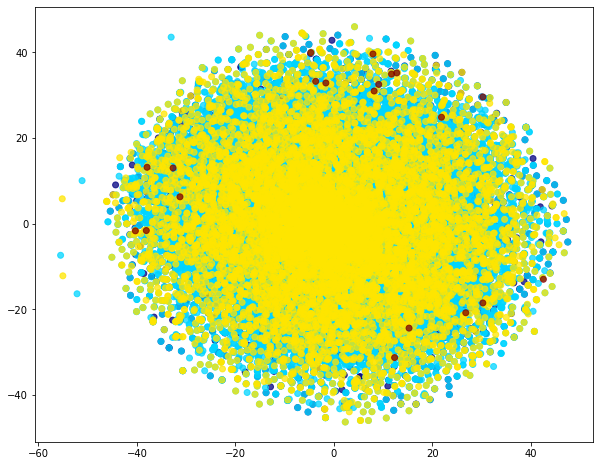

In [22]:
l = 0
node_ids = []
labels = []
df_list = [ nodes_author_df, nodes_paper_df, nodes_term_df, nodes_conf_df]

for _df in df_list:
    _df = _df.reset_index()
    col = list(_df.columns)[0]
    k = list(_df[col])
    node_ids.extend(k)
    labels.extend([l]*len(_df))
    l+=1


plt.figure(figsize=(10, 8))

node_colours = labels
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=0.75,
)


array([[ 0.81913644, -0.18086357],
       [ 0.81913096, -0.18086903],
       [ 0.8191326 , -0.18086739],
       ...,
       [ 0.8191324 , -0.18086758],
       [ 0.81913596, -0.18086407],
       [ 0.81913537, -0.18086462]], dtype=float32)

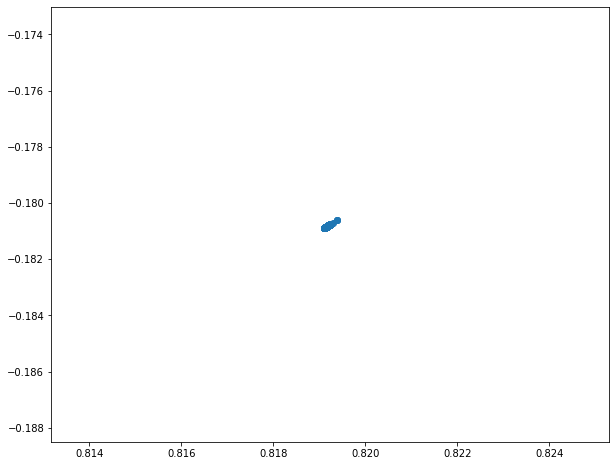

In [26]:
node_embeddings_2d.shape

(26128, 2)

In [35]:
node_embeddings_2d[:100]

array([[ 1.1483322e-06, -2.5354930e-07],
       [ 1.1483160e-06, -2.5355504e-07],
       [ 1.1483132e-06, -2.5355163e-07],
       [ 1.1483122e-06, -2.5355246e-07],
       [ 1.1483507e-06, -2.5355672e-07],
       [ 1.1483171e-06, -2.5355203e-07],
       [ 1.1483149e-06, -2.5354828e-07],
       [ 1.1483503e-06, -2.5354905e-07],
       [ 1.1483044e-06, -2.5355448e-07],
       [ 1.1483120e-06, -2.5354967e-07],
       [ 1.1483168e-06, -2.5354942e-07],
       [ 1.1483173e-06, -2.5355513e-07],
       [ 1.1483185e-06, -2.5355300e-07],
       [ 1.1483103e-06, -2.5354936e-07],
       [ 1.1483246e-06, -2.5355098e-07],
       [ 1.1483166e-06, -2.5354777e-07],
       [ 1.1483490e-06, -2.5355297e-07],
       [ 1.1483158e-06, -2.5355246e-07],
       [ 1.1483203e-06, -2.5354382e-07],
       [ 1.1483568e-06, -2.5355388e-07],
       [ 1.1483179e-06, -2.5355209e-07],
       [ 1.1483532e-06, -2.5355163e-07],
       [ 1.1483113e-06, -2.5355624e-07],
       [ 1.1483177e-06, -2.5354899e-07],
       [ 1.14832